In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt
import os
import pathlib

In [0]:
#Paths to the dataset
train_dir = '/content/gdrive/My Drive/dataset/1_train'
train_dir = pathlib.Path(train_dir)

valid_dir = '/content/gdrive/My Drive/dataset/2_validation'
valid_dir = pathlib.Path(valid_dir)

test_dir = '/content/gdrive/My Drive/dataset/3_test'
test_dir = pathlib.Path(test_dir)

#Inspect number of photos in each subset
train_count = len(list(train_dir.glob('*/*.png')))
valid_count = len(list(valid_dir.glob('*/*.png')))
test_count = len(list(test_dir.glob('*/*.png')))
print("Number of training photos:", train_count, "\nNumber of validation photos:", valid_count, "\nNumber of test photos:", test_count)

Number of training photos: 5600 
Number of validation photos: 800 
Number of test photos: 800


In [0]:
CLASS_NAMES = np.array(['bad', 'good'])
CLASS_NAMES[0]

'bad'

In [0]:
#Function for displaying batch with original and predicted classes
def show_batch(image_batch, label_batch, pred=[]):
  plt.figure(figsize=(15,15))
  for n in range(32):
      ax = plt.subplot(4,8,n+1)
      plt.imshow(image_batch[n])
      if len(pred)==0:
        plt.title(str(CLASS_NAMES[int(label_batch[n])]))
      else:
        plt.title("orig: "+str(CLASS_NAMES[int(label_batch[n])])+"\npred: "+str(CLASS_NAMES[int(pred[n])]))
      plt.axis('off')

In [0]:
#This batch size provides same size for every batch
#Image dimensions required for the input to Xception network
BATCH_SIZE = 32
IMG_HEIGHT = 229
IMG_WIDTH = 229

STEPS_PER_EPOCH = np.ceil(train_count/BATCH_SIZE)
STEPS_PER_EPOCH_V = np.ceil(valid_count/BATCH_SIZE)
STEPS_PER_EPOCH_T = np.ceil(test_count/BATCH_SIZE)

In [0]:
#Train batches generator
train_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.xception.preprocess_input)

train_generator = train_datagen.flow_from_directory(directory=str(train_dir),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    class_mode='binary')

Found 5600 images belonging to 2 classes.


In [0]:
# image_batch, label_batch = next(train_generator)
# print(image_batch, label_batch)

In [0]:
# show_batch(image_batch, label_batch)

In [0]:
#Validation batches generator
valid_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.xception.preprocess_input)

valid_generator = valid_datagen.flow_from_directory(directory=str(valid_dir),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    class_mode='binary')

Found 800 images belonging to 2 classes.


In [0]:
# image_batch, label_batch = next(valid_generator)
# print(image_batch, label_batch)

In [0]:
# show_batch(image_batch, label_batch)

In [0]:
#Test batches generator
test_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.xception.preprocess_input)

test_generator = test_datagen.flow_from_directory(directory=str(test_dir),
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                  class_mode='binary')

Found 800 images belonging to 2 classes.


In [0]:
# image_batch, label_batch = next(test_generator)
# print(image_batch, label_batch)

In [0]:
# show_batch(image_batch, label_batch)

In [0]:
#Import Xception model with weights trained on ImageNet dataset, without last layer
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(1, activation="sigmoid")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 1s 0us/step


In [0]:
#Freezing all Xception layers for first 5 epochs
#Unfreezed remain only avg and output layer
for layer in base_model.layers:
    layer.trainable = False

checkpoint_cb = keras.callbacks.ModelCheckpoint("/content/gdrive/My Drive/image_x_model_fr.h5", save_best_only=True)
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["binary_accuracy"])
history = model.fit(train_generator,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_generator,
                    validation_steps=STEPS_PER_EPOCH_V,
                    epochs=5,
                    callbacks=[checkpoint_cb])

Epoch 1/5
175/175 [==============================] - 2324s 13s/step - loss: 0.9044 - binary_accuracy: 0.7989 - val_loss: 0.5126 - val_binary_accuracy: 0.8075
Epoch 2/5
175/175 [==============================] - 48s 274ms/step - loss: 0.5981 - binary_accuracy: 0.8264 - val_loss: 0.4536 - val_binary_accuracy: 0.8363
Epoch 3/5
175/175 [==============================] - 47s 270ms/step - loss: 0.3990 - binary_accuracy: 0.8539 - val_loss: 0.4739 - val_binary_accuracy: 0.8300
Epoch 4/5
175/175 [==============================] - 48s 274ms/step - loss: 0.3685 - binary_accuracy: 0.8618 - val_loss: 0.4448 - val_binary_accuracy: 0.8225
Epoch 5/5
175/175 [==============================] - 48s 276ms/step - loss: 0.3360 - binary_accuracy: 0.8673 - val_loss: 0.4161 - val_binary_accuracy: 0.8475


In [0]:
#Unfreezing base model layers for next epochs
for layer in base_model.layers:
    layer.trainable = True

checkpoint_cb = keras.callbacks.ModelCheckpoint("/content/gdrive/My Drive/image_x_model_fr.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["binary_accuracy"])
history = model.fit(train_generator,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_generator,
                    validation_steps=STEPS_PER_EPOCH_V,
                    epochs=100,
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
175/175 [==============================] - 74s 424ms/step - loss: 0.2561 - binary_accuracy: 0.8832 - val_loss: 0.1201 - val_binary_accuracy: 0.9550
Epoch 2/100
175/175 [==============================] - 72s 409ms/step - loss: 0.1160 - binary_accuracy: 0.9450 - val_loss: 0.1292 - val_binary_accuracy: 0.9475
Epoch 3/100
175/175 [==============================] - 74s 425ms/step - loss: 0.0665 - binary_accuracy: 0.9677 - val_loss: 0.0909 - val_binary_accuracy: 0.9600
Epoch 4/100
175/175 [==============================] - 74s 424ms/step - loss: 0.0511 - binary_accuracy: 0.9786 - val_loss: 0.0869 - val_binary_accuracy: 0.9638
Epoch 5/100
175/175 [==============================] - 72s 411ms/step - loss: 0.0437 - binary_accuracy: 0.9802 - val_loss: 0.1004 - val_binary_accuracy: 0.9638
Epoch 6/100
175/175 [==============================] - 74s 423ms/step - loss: 0.0327 - binary_accuracy: 0.9854 - val_loss: 0.0714 - val_binary_accuracy: 0.9750
Epoch 7/100
175/175 [===================

In [0]:
from sklearn.metrics import confusion_matrix

image_batch, label_batch = next(test_generator)

y_pred = model.predict(image_batch)

print(label_batch)
pred = []
for x in y_pred:
  if x >= 0.5:
    pred.append(1)
  else:
    pred.append(0)
print(pred)

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [0]:
confusion_matrix(label_batch.astype('int'), pred)

array([[26,  4],
       [ 1,  1]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

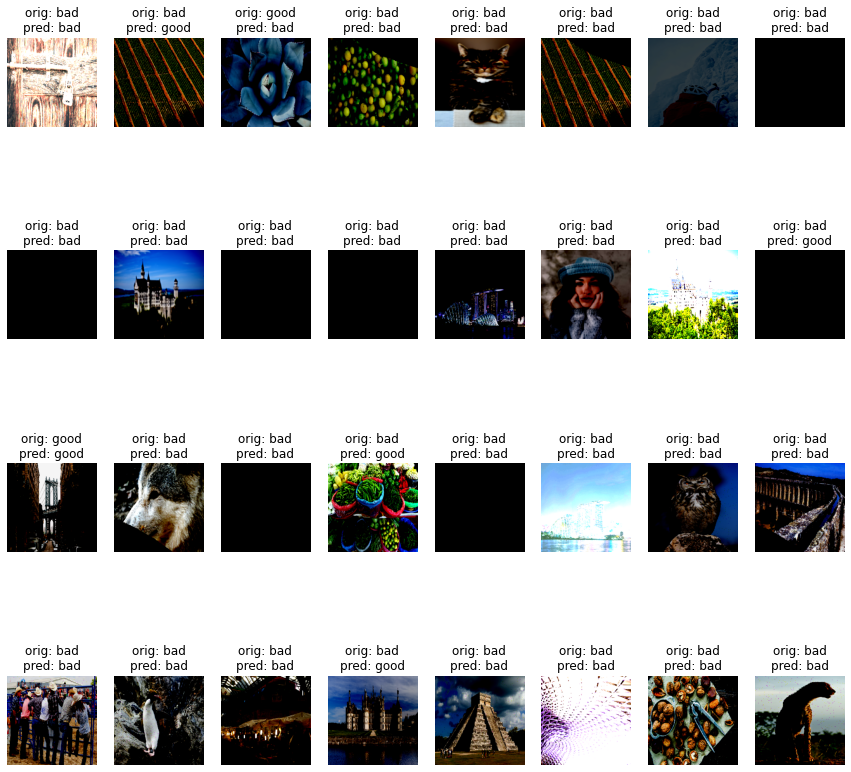

In [0]:
show_batch(image_batch, label_batch, pred)